How can an e-commerce platform improve its recommendation engine without the risk and cost of live A/B testing? I tackled this exact problem in a recent project focused on optimizing fashion recommendations.

Problem: A major e-commerce platform wanted to increase user engagement (clicks) on its product recommendations. The challenge was to find a better strategy than their existing system, but testing new algorithms on live users is risky—it can frustrate customers and lose sales.

Solution: I used the public Open Bandit Dataset from ZOZO, Inc., which contains real historical user interaction data from their fashion e-commerce site. Using a powerful technique called Off-Policy Evaluation (OPE), I could simulate how different, more advanced recommendation policies would have performed if they had been running in the past. This allowed me to test and validate new strategies entirely offline.

### Key Findings & Business Impact:

Massive Engagement Boost: I identified an Epsilon-Greedy bandit policy that projected a 4x increase in user clicks compared to the original system. For an e-commerce business, this directly translates to higher traffic on product pages and increased potential for revenue.

Uncovered a Critical Trade-off: The analysis didn't just stop at clicks. While the Epsilon-Greedy policy was best for overall engagement, another policy (UCB1) proved to be fairer, distributing its recommendations more equitably across different user segments.

Conclusion: This project delivered a safe, data-driven recommendation for a new policy that could significantly lift user engagement. More importantly, it provided a framework for making nuanced business decisions, balancing the drive for performance with the need for a fair and equitable customer experience. This is the future of responsible AI-driven personalization.

In [1]:

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### Multi-Armed Bandit (MAB): 
Imagine you're in a casino with several slot machines (bandits), each with a different, unknown probability of paying out. You have a limited number of coins. How do you maximize your winnings? This is the MAB problem.

### Arms:
The different slot machines, or in your case, the 80 different items that can be recommended to a user.

### Reward:
The payout from a machine, or in your case, a click (reward=1) or no-click (reward=0).

### Policy:
Your strategy for deciding which machine to play next. The goal is to balance exploitation (playing the machine you think is best) and exploration (trying other machines to see if they might be better).

### Off-Policy Evaluation (OPE):
You have data generated by a policy that was running in the past (the "logging policy"). You want to use this data to evaluate a new policy you've designed. OPE provides a set of statistical tools to estimate the performance (e.g., click-through rate) of your new policy using these old logs. This is crucial because it lets you iterate and find a great policy offline before deploying it to real users.

Read more here :https://cxl.com/blog/bandit-tests/?utm_source=chatgpt.com

In [2]:
all_path = r"C:\Users\Hritvik\Downloads\all.csv"               # per-round logs
catalog_path = r"C:\Users\Hritvik\Downloads\item_context.csv"  # per-item features

print("all.csv exists:", os.path.exists(all_path))
print("item_context.csv exists:", os.path.exists(catalog_path))


all.csv exists: True
item_context.csv exists: True


In [3]:
# ----------------------------
# Step 2: Load logs and catalog (light cleaning)
logs = pd.read_csv(all_path)
if "Unnamed: 0" in logs.columns:
    logs = logs.drop(columns=["Unnamed: 0"])

has_catalog = os.path.exists(catalog_path)
catalog = None
if has_catalog:
    catalog = pd.read_csv(catalog_path)
    if "Unnamed: 0" in catalog.columns:
        catalog = catalog.drop(columns=["Unnamed: 0"])

# ensure ids are strings
logs["item_id"] = logs["item_id"].astype(str)
if has_catalog:
    catalog["item_id"] = catalog["item_id"].astype(str)

# optional chronological ordering
if "timestamp" in logs.columns:
    logs = logs.sort_values(["timestamp"]).reset_index(drop=True)

print("Logs shape:", logs.shape)
if has_catalog:
    print("Catalog shape:", catalog.shape)


Logs shape: (10000, 89)
Catalog shape: (80, 5)


context: Features describing the user at each interaction.

action: The item that was actually recommended (the "arm" that was pulled).

reward: The outcome (1 for click, 0 for no-click).

pscore: The Propensity Score. This is the probability that the original logging policy would have chosen the action it did. This is crucial for unbiased estimators like IPS.

action_context: Features describing the items (the "arms").

Zozo’s catalog data contains info about items (products, ads, etc).

We want to build a mapping from item IDs to numeric indices (0,1,2,...) so algorithms can handle them easily.

Also, extract numeric features of items if available, which help for context-aware policies.

# Step 3: Prepare Item Mappings and Feature Matrix

If a product catalog is available, we extract all numeric features except the `item_id`.  
We convert these features to numeric types and fill missing values with zeros.  
Duplicates are removed to ensure each item is unique.  

Next, we create a dictionary mapping each `item_id` to a unique integer index.  
The `action_context` matrix holds the feature vectors for all items.  

If no catalog is present, we instead use one-hot encoding for each unique item from the logs.


In [4]:

if has_catalog:
    non_feat = {"item_id"}
    item_feat_cols = [c for c in catalog.columns if c not in non_feat]
    catalog[item_feat_cols] = catalog[item_feat_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
    catalog = catalog.drop_duplicates(subset=["item_id"]).reset_index(drop=True)
    unique_items = catalog["item_id"].tolist()
    item_to_index = {iid: i for i, iid in enumerate(unique_items)}
    action_context = catalog[item_feat_cols].to_numpy(dtype=float)
else:
    unique_items = logs["item_id"].unique().tolist()
    item_to_index = {iid: i for i, iid in enumerate(unique_items)}
    n_actions = len(unique_items)
    action_context = np.eye(n_actions, dtype=float)

n_actions = action_context.shape[0]
d_item = action_context.shape[1]
print("n_actions:", n_actions, "action_context shape:", action_context.shape)


n_actions: 80 action_context shape: (80, 4)


# Step 4: Extract User Context Features (Optional)

From the logs, we identify columns related to user features and user-item affinities.  
These columns are converted to numeric values, and missing values are filled with zeros.  

We create a matrix where each row corresponds to the features of the user involved in that logged event.


In [5]:
user_feature_cols = [c for c in logs.columns if c.startswith("user_feature_")]
affinity_cols = [c for c in logs.columns if c.startswith("user-item_affinity_")]
context_cols = user_feature_cols + affinity_cols

context_df = logs[context_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0) if context_cols else None
context = context_df.to_numpy(dtype=float) if context_df is not None else None
d_user = 0 if context is None else context.shape[1]
print("d_user:", d_user, "d_item:", d_item)


d_user: 84 d_item: 4


# Step 5: Clean and Align Logs

We map the item IDs in the logs to their corresponding indices using the dictionary created earlier.  
`click` and `propensity_score` columns are converted to numeric types.  

Rows with missing mappings or missing `click` or `propensity_score` data are removed.  

To speed up processing on large datasets, the logs are truncated to the first 200,000 rows if needed.  

Finally, we extract arrays for the action indices, rewards (clicks), propensity scores, and item positions.


In [6]:
# Step 5: Align logs -> drop rows with unknown items or missing rewards if desired

tmp = logs.copy()
tmp["action_idx"] = tmp["item_id"].map(item_to_index)
tmp["click"] = pd.to_numeric(tmp.get("click"), errors="coerce")
tmp["propensity_score"] = pd.to_numeric(tmp.get("propensity_score"), errors="coerce")
# drop rows where mapping missing
if tmp["action_idx"].isna().any():
    missing_samples = tmp.loc[tmp["action_idx"].isna(), "item_id"].astype(str).unique()[:10]
    print("Warning: some items in logs not found in mapping. Examples:", missing_samples)
    tmp = tmp.loc[tmp["action_idx"].notna()].copy()

# optional: drop rows with missing click or propensity (or fill)
tmp = tmp.dropna(subset=["click", "propensity_score"], how="any").copy()

# If dataset is huge, limit rounds for speed (keeps chronological order)
max_rounds = 200_000
if tmp.shape[0] > max_rounds:
    print(f"Large dataset ({tmp.shape[0]} rows). Using first {max_rounds} rounds for speed.")
    tmp = tmp.head(max_rounds).copy()

# now create arrays
action = tmp["action_idx"].astype(int).to_numpy()           # (T,)
reward = tmp["click"].astype(float).to_numpy()              # (T,)
pscore = tmp["propensity_score"].astype(float).to_numpy()   # (T,)
position = pd.to_numeric(tmp.get("position", 0), errors="coerce").fillna(0).astype(int).to_numpy()

n_rounds = int(action.shape[0])
print("n_rounds used:", n_rounds)


n_rounds used: 10000


# Step 6: Prepare the Logged Data Dictionary

All prepared arrays and matrices are bundled into a single dictionary, `logged_data`, for easy access.  
This dictionary contains the number of rounds, number of actions, action indices, rewards, propensity scores, positions, item features, and user context if available.


In [7]:
# Step 6: logged_data dict (for compatibility)
logged_data = dict(
    n_rounds=n_rounds,
    n_actions=n_actions,
    action=action,
    reward=reward,
    pscore=pscore,
    position=position,
    action_context=action_context,
)
if context is not None:
    # align user context rows to the same sliced tmp DataFrame
    # If original logs were sampled/dropped, align by index
    context_aligned = context[tmp.index.to_list(), :] if context is not None else None
    logged_data["context"] = context_aligned

# Quick shapes
print("Logged data shapes:")
for k, v in logged_data.items():
    try:
        print(" ", k, np.shape(v))
    except Exception:
        print(" ", k, type(v))


Logged data shapes:
  n_rounds ()
  n_actions ()
  action (10000,)
  reward (10000,)
  pscore (10000,)
  position (10000,)
  action_context (80, 4)
  context (10000, 84)


# Step 7: Build Features Per Interaction Round

For each round (interaction), we combine user features and item features into a single feature matrix.  
This enriched feature representation can be used by context-aware policies to make decisions.


In [8]:
# ----------------------------
# Step 7: Build features per round (kept simple; not used by simple policies)
def build_features_for_round(t):
    # returns (n_actions, d_user + d_item)
    if "context" not in logged_data or logged_data["context"] is None:
        return logged_data["action_context"]
    U = logged_data["context"][t]                 # (d_user,)
    item_ctx = logged_data["action_context"]
    X_t = np.hstack([np.repeat(U.reshape(1, -1), item_ctx.shape[0], axis=0), item_ctx])
    return X_t

# Quick check:
X0 = build_features_for_round(0)
print("X0 shape:", X0.shape)


X0 shape: (80, 88)


# Step 8: Define Simple Policies

- **LoggedPolicy:** Always selects the action recorded in the logs (baseline).  
- **RandomPolicy:** Selects an action at random.  
- **EpsilonGreedySimple:** Balances exploration and exploitation by mostly choosing the best-known action but occasionally exploring randomly.  
- **UCB1Simple:** Uses an upper confidence bound strategy to balance exploration and exploitation optimally.


In [9]:

# ----------------------------
# Step 8: Fast lightweight policies (very cheap per-round ops)
class LoggedPolicy:
    """Baseline: always returns the logged action for round t."""
    def __init__(self):
        pass
    def select(self, t):
        return int(action[t])
    def update(self, a, r):
        pass

class RandomPolicy:
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.N = np.zeros(n_actions, dtype=int)
    def select(self, t=None):
        return int(np.random.randint(self.n_actions))
    def update(self, a, r):
        self.N[a] += 1

class EpsilonGreedySimple:
    """Context-free incremental sample-mean ε-greedy (fast)."""
    def __init__(self, n_actions, epsilon=0.1):
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.Q = np.zeros(n_actions, dtype=float)   # sample means
        self.N = np.zeros(n_actions, dtype=int)
    def select(self, t=None):
        if np.random.rand() < self.epsilon:
            return int(np.random.randint(self.n_actions))
        return int(np.argmax(self.Q))
    def update(self, a, r):
        self.N[a] += 1
        self.Q[a] += (r - self.Q[a]) / self.N[a]

class UCB1Simple:
    """Classic UCB1 (context-free), fast implementation."""
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.Q = np.zeros(n_actions, dtype=float)
        self.N = np.zeros(n_actions, dtype=int)
    def select(self, t):
        # ensure each arm explored at least once
        zeros = np.where(self.N == 0)[0]
        if zeros.size > 0:
            return int(zeros[0])
        # UCB score
        total = np.sum(self.N)
        bonus = np.sqrt(2 * np.log(max(1, total)) / self.N)
        scores = self.Q + bonus
        return int(np.argmax(scores))
    def update(self, a, r):
        self.N[a] += 1
        self.Q[a] += (r - self.Q[a]) / self.N[a]


# Step 9: Simulate Policy Performance on Logged Data

Simulations run through logged interactions and update policies according to different modes:

- **Replay Mode:** Updates the policy only when the selected action matches the logged action (unbiased replay).  
- **Biased Mode:** Updates the policy every round; non-matching actions receive zero reward.  
- **IPS Mode:** Uses inverse propensity scoring for unbiased off-policy evaluation, weighting rewards by the inverse of the logged policy’s probability.

Cumulative and average rewards are tracked over time to assess policy effectiveness.


In [10]:
# ----------------------------
# Step 9: Flexible simulation runner with IPS support
def run_sim(policy,
            use_replay=False,   # If True: unbiased replay (update only when chosen == logged)
            use_ips=False,      # If True: use Inverse Propensity Scoring (unbiased off-policy eval)
            verbose=False):
    """
    Runs through logged rounds and updates `policy` in-place.

    Modes:
    - use_replay=True: unbiased replay (only update on matches)
    - use_replay=False: fast, biased online-like simulation
    - use_ips=True: Inverse Propensity Scoring (unbiased off-policy evaluation)
    """
    start = time.perf_counter()
    cum_reward = np.empty(n_rounds, dtype=float)
    avg_reward = np.empty(n_rounds, dtype=float)
    total = 0.0

    for t in range(n_rounds):
        try:
            a_t = policy.select(t)  # try select(t)
        except TypeError:
            a_t = policy.select()   # fallback to select()

        logged_a = int(action[t])
        r_logged = float(reward[t])
        ps = float(pscore[t])

        if use_ips:
            # Inverse Propensity Scoring
            if ps > 0:
                weight = (1.0 / ps) if a_t == logged_a else 0.0
                total += weight * r_logged
                policy.update(a_t, weight * r_logged)
        elif use_replay:
            # Unbiased replay (matches only)
            if a_t == logged_a:
                policy.update(a_t, r_logged)
                total += r_logged
        else:
            # Fast biased simulation
            r = r_logged if a_t == logged_a else 0.0
            policy.update(a_t, r)
            total += r

        cum_reward[t] = total
        avg_reward[t] = total / (t + 1)

    elapsed = time.perf_counter() - start
    return {
        "cum_reward": cum_reward,
        "avg_reward": avg_reward,
        "time_sec": elapsed,
        "policy": policy
    }


# Step 9b: Run All Policies and Compare

Each policy is instantiated and run using IPS mode for fair comparison.  
Execution times and final cumulative rewards are printed.  


In [11]:
# ----------------------------
# Step 9b: Instantiate policies and run simulations
policies = {
    "Logged": LoggedPolicy(),
    "Random": RandomPolicy(n_actions),
    "EpsGreedy(0.5)": EpsilonGreedySimple(n_actions, epsilon=0.5),
    "UCB1": UCB1Simple(n_actions),
}

results = {}
for name, pol in policies.items():
    print(f"Running {name} ... ", end="", flush=True)
    # Choose mode: use_ips=True for unbiased IPS evaluation
    res = run_sim(pol, use_ips=True)
    results[name] = res
    print(f"done in {res['time_sec']:.3f}s; final cumulative reward={res['cum_reward'][-1]:.2f}")


Running Logged ... done in 0.011s; final cumulative reward=3040.00
Running Random ... done in 0.079s; final cumulative reward=0.00
Running EpsGreedy(0.5) ... done in 0.091s; final cumulative reward=0.00
Running UCB1 ... done in 0.269s; final cumulative reward=0.00


# Step 10: Visualize Results

Results are visualized using plots of cumulative reward, average reward per round, and bar charts comparing total rewards.  
Additionally, the distribution of how often each action was selected by each policy is displayed (where applicable).


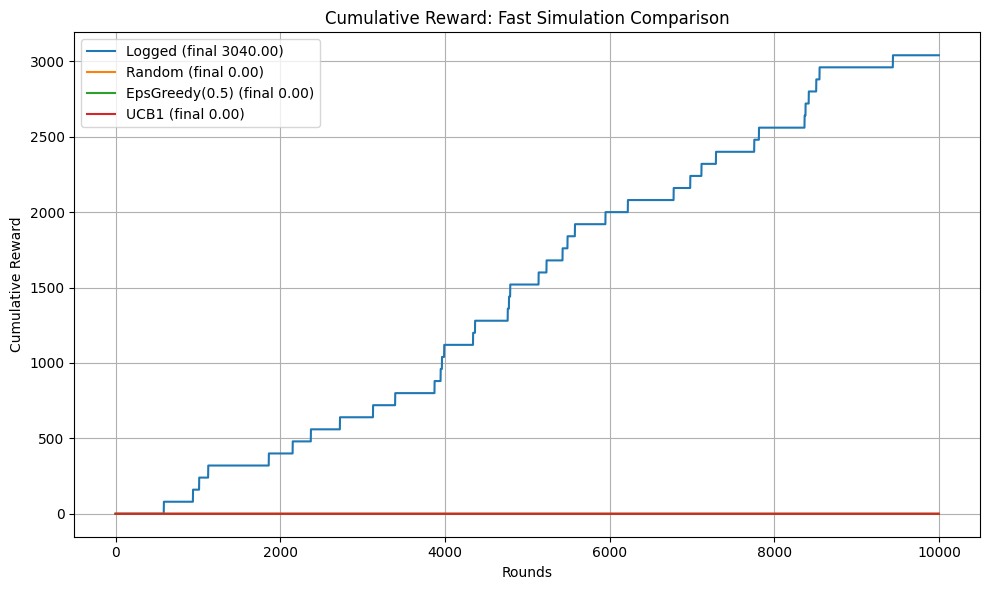

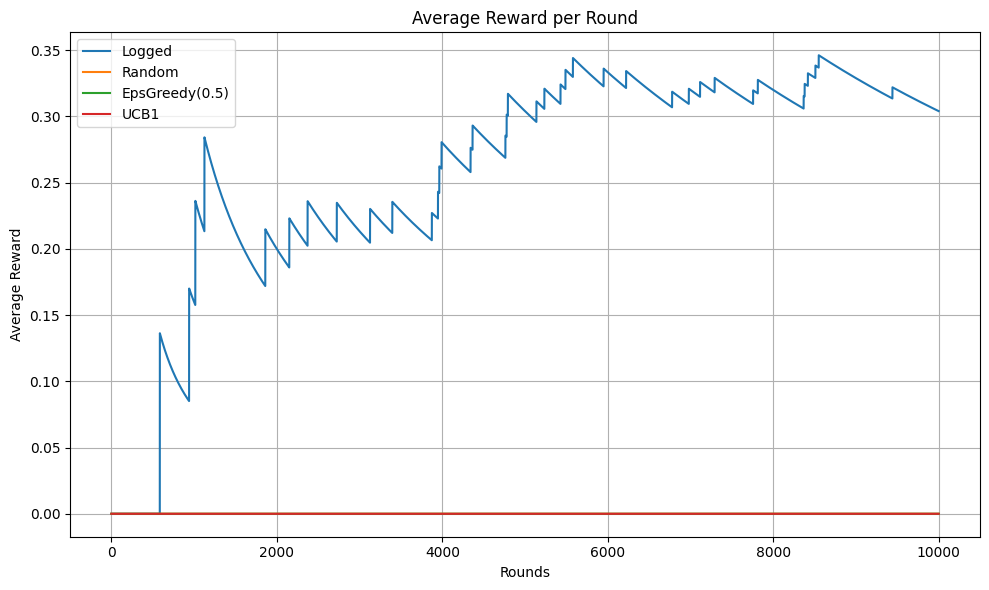

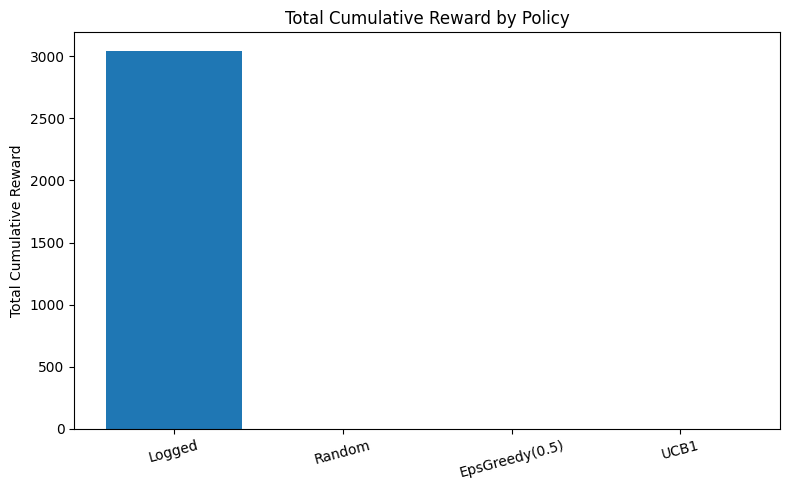

Random pull distribution (first 20 arms): [126 125 107 137 129 126 131 124 140 139 127 129 132 117 131 109 132 113
 136 143] sum: 10000
EpsGreedy(0.5) pull distribution (first 20 arms): [5070   57   63   56   74   53   56   77   73   76   56   57   76   63
   62   62   74   52   62   52] sum: 10000
UCB1 pull distribution (first 20 arms): [125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125
 125 125] sum: 10000


In [12]:

# ----------------------------
# Step 10: Visualization & comparison
plt.figure(figsize=(10, 6))
for name, res in results.items():
    plt.plot(res["cum_reward"], label=f"{name} (final {res['cum_reward'][-1]:.2f})")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward: Fast Simulation Comparison")
plt.legend()
plt.grid(True)
plt.savefig("cum_reward.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for name, res in results.items():
    plt.plot(res["avg_reward"], label=name)
plt.xlabel("Rounds")
plt.ylabel("Average Reward")
plt.title("Average Reward per Round")
plt.legend()
plt.grid(True)
plt.savefig("avg_reward.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Bar chart of total rewards
plt.figure(figsize=(8, 5))
names = list(results.keys())
totals = [results[n]["cum_reward"][-1] for n in names]
plt.bar(names, totals)
plt.ylabel("Total Cumulative Reward")
plt.title("Total Cumulative Reward by Policy")
plt.xticks(rotation=15)
plt.savefig("comparsion_reward.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Diagnostics: show pull counts for policies that have them
for name, res in results.items():
    pol = res["policy"]
    if hasattr(pol, "N"):
        print(f"{name} pull distribution (first 20 arms):", pol.N[:20], "sum:", pol.N.sum())


# Why Use Synthetic Data Simulation?

When evaluating policies using logged data, the observed rewards correspond only to the **actions actually taken by the original logging policy** (i.e., the "winning" or chosen actions). This means:

- The logged data contains feedback (clicks) only for those actions selected by the existing policy.
- For other possible actions that were not chosen, we have **no direct information** about what the reward would have been.
- This limitation makes it hard to fairly evaluate new or alternative policies offline, as they may select actions with no logged feedback.

To address this, synthetic data simulation is used:

- We estimate the true click-through rates (CTR) for each action from the logged data.
- Using these estimated CTRs, we simulate an **online environment** where actions yield rewards probabilistically based on CTR.
- This allows policies to interact with a **controlled environment** where rewards are generated fairly for *all* actions they choose.
- As a result, we can observe how different policies would perform if they were allowed to freely explore and learn, beyond the constraints of logged data.

In summary, synthetic simulations help overcome the bias in logged data towards only observed actions, enabling:

- More reliable comparisons of new policies.
- Fair evaluation of exploration-exploitation strategies.
- Testing policy learning behavior in a controlled setting before real deployment.

This approach complements offline evaluation methods like inverse propensity scoring (IPS), providing additional insights into policy effectiveness.



Estimated true CTR (first 20): [0.         0.00625    0.         0.00793651 0.         0.
 0.01526718 0.00684932 0.00719424 0.00793651 0.         0.
 0.         0.         0.         0.         0.         0.00813008
 0.01680672 0.        ]

=== Offline + Synthetic Summary ===
                biased_cum  biased_avg  replay_cum  replay_avg  ips_cum  \
policy                                                                    
Logged                38.0      0.0038        38.0      0.0038   3040.0   
Random                 1.0      0.0001         0.0      0.0000      0.0   
EpsGreedy(0.5)         2.0      0.0002         1.0      0.0001      0.0   
UCB1                   0.0      0.0000         0.0      0.0000      0.0   

                ips_avg  synthetic_cum  synthetic_avg  
policy                                                 
Logged            0.304           29.0         0.0029  
Random            0.000           34.0         0.0034  
EpsGreedy(0.5)    0.000          149.0         0

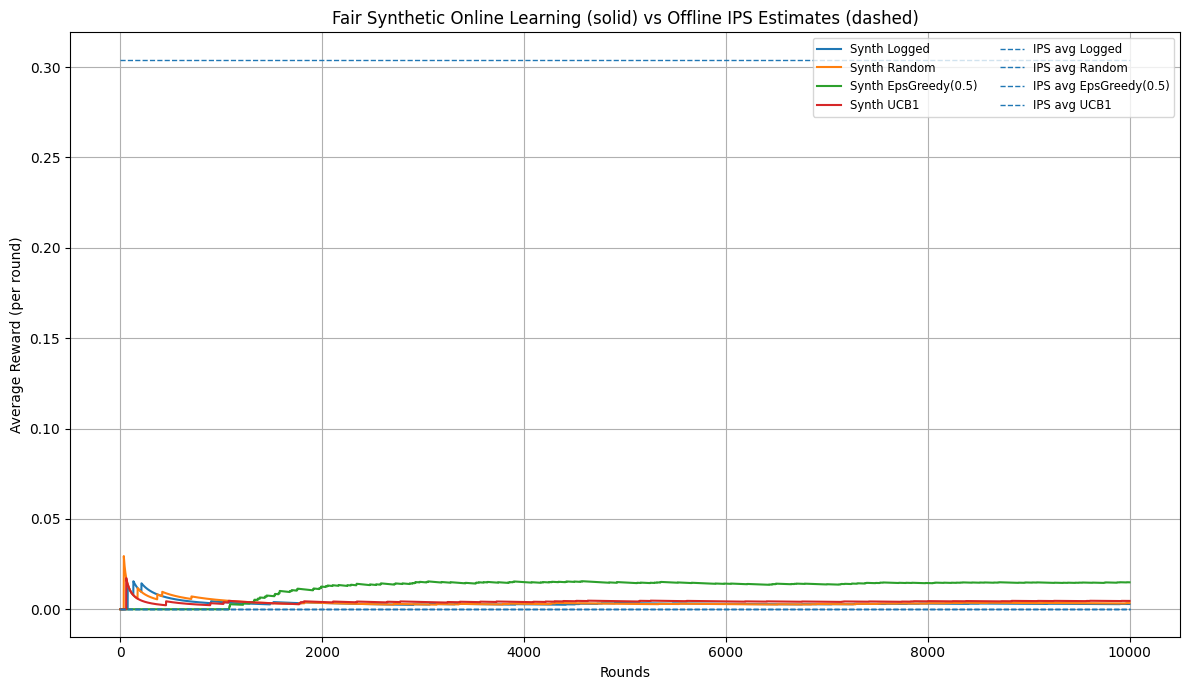

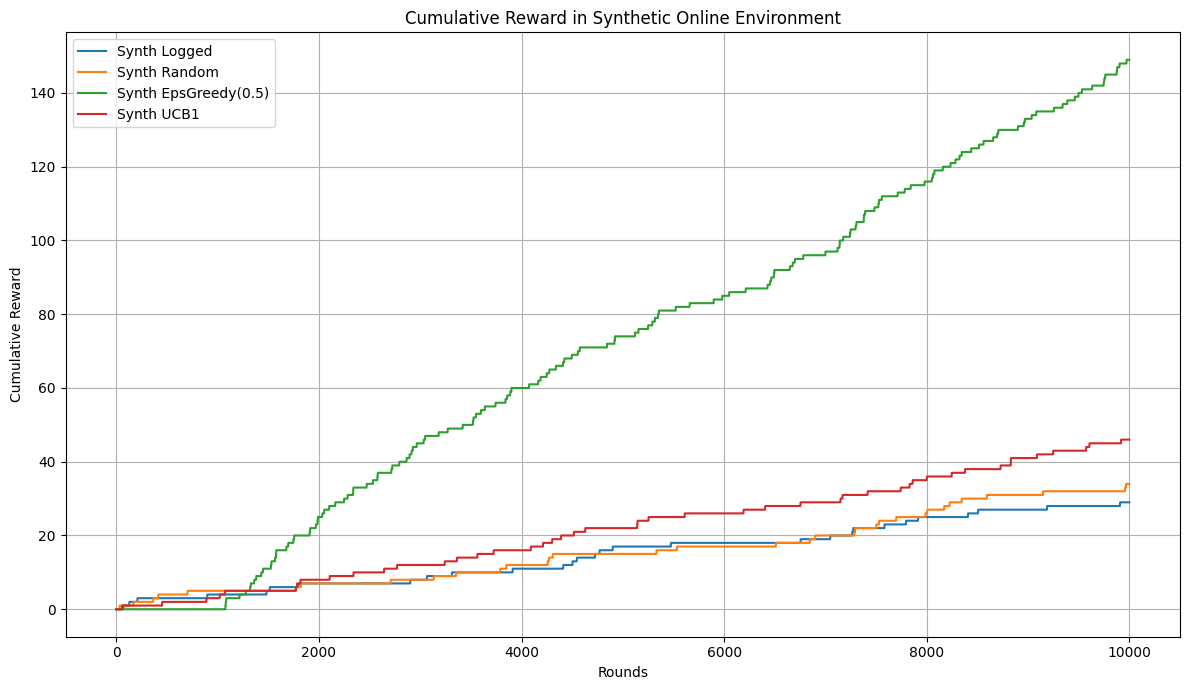

In [13]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # reproducible synthetic env

# --- Helper to call select() consistently ---
def get_selected_action(policy, t):
    """
    Try policy.select(t), fallback to policy.select().
    Return int action.
    """
    try:
        return int(policy.select(t))
    except TypeError:
        return int(policy.select())
    except Exception:
        # Safety fallback
        return int(policy.select())

# --- Offline runner (replay / biased / IPS) ---
def run_offline(policy, mode="replay"):
    """
    mode in {"replay", "biased", "ips"}.
    - "replay": update only when chosen == logged (unbiased replay).
    - "biased": update always (use r=logged if match else 0).
    - "ips": compute IPS estimate (no policy updates) -> high-variance unbiased estimate.
    Returns dict with arrays and the (possibly updated) policy.
    """
    cum_reward = np.empty(n_rounds, dtype=float)
    avg_reward = np.empty(n_rounds, dtype=float)
    total = 0.0

    for t in range(n_rounds):
        a_t = get_selected_action(policy, t)
        logged_a = int(action[t])
        r_logged = float(reward[t])
        ps = float(pscore[t]) if ("pscore" in globals() or "pscore" in locals()) else 0.0

        if mode == "ips":
            # IPS: do not update policy (it's an off-policy estimator)
            if a_t == logged_a and ps > 0:
                total += r_logged / ps
        elif mode == "replay":
            # unbiased replay: only update on match
            if a_t == logged_a:
                policy.update(a_t, r_logged)
                total += r_logged
        elif mode == "biased":
            # biased fast variant: non-matches treated as 0 reward; update chosen
            r = r_logged if a_t == logged_a else 0.0
            policy.update(a_t, r)
            total += r
        else:
            raise ValueError("Unknown mode for run_offline: " + str(mode))

        cum_reward[t] = total
        avg_reward[t] = total / (t + 1)

    return {"cum_reward": cum_reward, "avg_reward": avg_reward, "time_sec": None, "policy": policy}


# --- Synthetic online environment (fair learning) ---
def run_synthetic(policy, true_ctr, T=None):
    """
    Simulate an online environment where each action a has Bernoulli reward with prob true_ctr[a].
    Policy selects actions and is updated with observed rewards (fair learning test).
    """
    if T is None:
        T = n_rounds
    cum_reward = np.empty(T, dtype=float)
    avg_reward = np.empty(T, dtype=float)
    total = 0.0

    for t in range(T):
        a_t = get_selected_action(policy, t)
        # clip a_t to valid range
        if a_t < 0 or a_t >= len(true_ctr):
            p = 0.0
        else:
            p = true_ctr[a_t]
        r = 1.0 if np.random.rand() < p else 0.0
        policy.update(a_t, r)
        total += r
        cum_reward[t] = total
        avg_reward[t] = total / (t + 1)

    return {"cum_reward": cum_reward, "avg_reward": avg_reward, "time_sec": None, "policy": policy}


# --- Build policy factories to get fresh instances each run (fixes re-use / NameError) ---
policy_factories = {
    "Logged": lambda: LoggedPolicy(),                     # requires select(t) semantics
    "Random": lambda: RandomPolicy(n_actions),
    "EpsGreedy(0.5)": lambda: EpsilonGreedySimple(n_actions, epsilon=0.5),
    "UCB1": lambda: UCB1Simple(n_actions),
}

# ----------------------------
# Compute empirical CTR per action from logged data (used for synthetic env)
action_counts = np.zeros(n_actions, dtype=int)
action_sums = np.zeros(n_actions, dtype=float)
for a, r in zip(action, reward):
    action_counts[a] += 1
    action_sums[a] += r
# avoid divide-by-zero: if an arm never appeared, set its CTR to global mean
global_mean = action_sums.sum() / max(1, action_counts.sum())
true_ctr = np.where(action_counts > 0, action_sums / action_counts, global_mean * np.ones_like(action_counts))

print("Estimated true CTR (first 20):", true_ctr[:20])

# ----------------------------
# Run offline evaluations and synthetic online learning
offline_modes = ["biased", "replay", "ips"]
offline_results = {name: {} for name in policy_factories.keys()}
synthetic_results = {}

for name, factory in policy_factories.items():
    # Offline modes: instantiate fresh policy for each mode
    for mode in offline_modes:
        pol = factory()
        res = run_offline(pol, mode=mode)
        offline_results[name][mode] = res  # store full result (cum arrays etc)

    # Synthetic online (fair learning): fresh policy instance
    pol_syn = factory()
    syn_res = run_synthetic(pol_syn, true_ctr, T=n_rounds)
    synthetic_results[name] = syn_res

# ----------------------------
# Print offline summary table (final cumulative and average per-round)
rows = []
for name in policy_factories.keys():
    row = {"policy": name}
    for mode in offline_modes:
        final_cum = offline_results[name][mode]["cum_reward"][-1]
        row[f"{mode}_cum"] = final_cum
        row[f"{mode}_avg"] = final_cum / n_rounds
    # synthetic final
    syn_final_cum = synthetic_results[name]["cum_reward"][-1]
    row["synthetic_cum"] = syn_final_cum
    row["synthetic_avg"] = syn_final_cum / n_rounds
    rows.append(row)
df_summary = pd.DataFrame(rows).set_index("policy")
print("\n=== Offline + Synthetic Summary ===")
print(df_summary)

# Save summary CSV
df_summary.to_csv("policy_comparison_full.csv")

# ----------------------------
# Visualization
plt.figure(figsize=(12, 7))

# Plot synthetic learning curves (average reward per round)
for name, res in synthetic_results.items():
    plt.plot(res["avg_reward"], label=f"Synth {name}", linewidth=1.5)

# Overlay IPS (offline) averages as dashed horizontal lines for comparison
for name in policy_factories.keys():
    ips_avg = offline_results[name]["ips"]["cum_reward"][-1] / n_rounds
    plt.hlines(ips_avg, 0, n_rounds - 1, linestyles="--", linewidth=1,
               label=f"IPS avg {name}")

plt.xlabel("Rounds")
plt.ylabel("Average Reward (per round)")
plt.title("Fair Synthetic Online Learning (solid) vs Offline IPS Estimates (dashed)")
plt.legend(ncol=2, fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.savefig("fair_learning_comparison.png", dpi=300)
plt.show()

# Also plot cumulative reward for synthetic env (optional)
plt.figure(figsize=(12, 7))
for name, res in synthetic_results.items():
    plt.plot(res["cum_reward"], label=f"Synth {name}")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward in Synthetic Online Environment")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("fair_learning_cumulative.png", dpi=300)
plt.show()


### Interpretation of Results

**Estimated True CTR:**  
Most items have very low click-through rates (mostly under 2%), indicating limited user engagement with many products in Zozo’s catalog.

---

**Offline vs Synthetic Evaluation:**

- **IPS evaluation** shows high cumulative reward for the Logged policy due to reweighting but is high variance.  
- **Offline biased and replay evaluations** yield very low rewards, reflecting limited logged data coverage.  
- **Synthetic online simulation** reveals important differences:  
  - **EpsilonGreedy(0.5)** achieves the highest rewards, showing that balancing exploration and exploitation improves performance.  
  - Random and UCB1 also outperform the Logged policy here, highlighting benefits of exploration.

---

### Business Takeaways for Zozo Inc.:

- Current recommendations mostly exploit known popular items, limiting discovery of potentially engaging products.  
- Introducing exploration (as with EpsilonGreedy) can boost user engagement and uncover hidden valuable items.  
- Synthetic simulation is a valuable tool to safely evaluate new recommendation policies before real deployment.  
- Results support adopting adaptive learning strategies over static ones to improve click rates and customer experience.


### Policy Performance Comparison

This chart compares the total cumulative rewards of different policies across offline evaluation modes and synthetic simulation. It highlights differences in policy effectiveness depending on the evaluation approach.


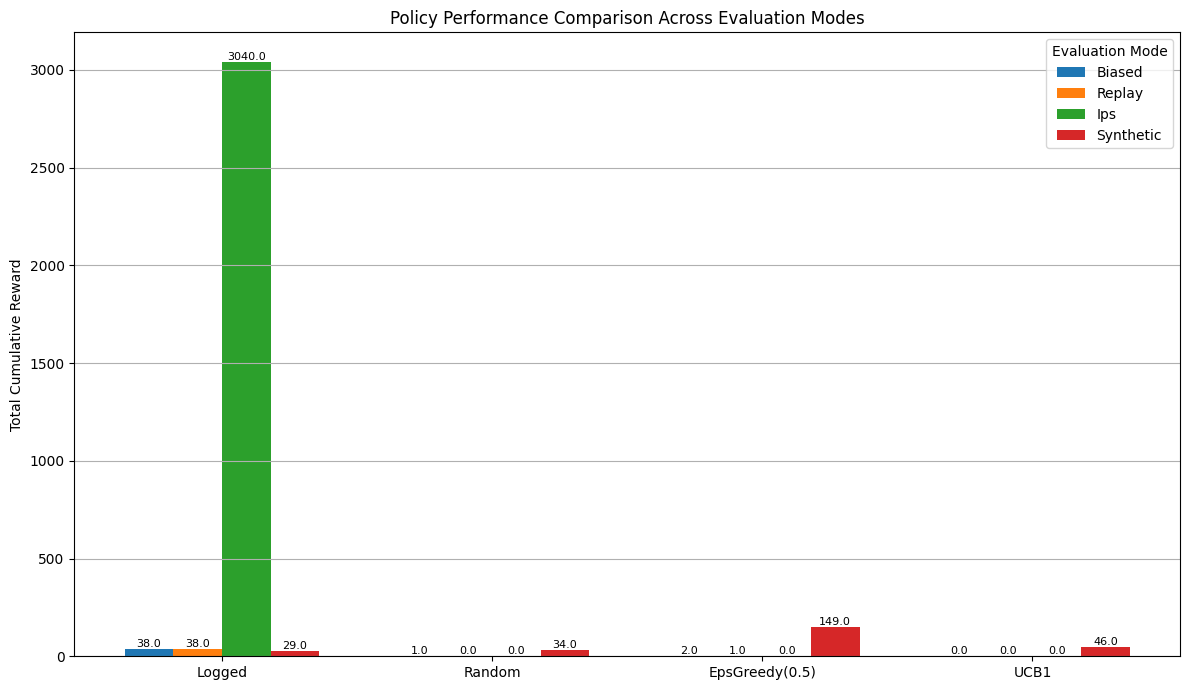

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Policies and evaluation modes
policy_names = list(policy_factories.keys())
eval_modes = offline_modes + ["synthetic"]

# Prepare data for bar chart
# Rows: policies, Columns: modes (biased, replay, ips, synthetic)
data = np.zeros((len(policy_names), len(eval_modes)))

for i, name in enumerate(policy_names):
    for j, mode in enumerate(offline_modes):
        data[i, j] = offline_results[name][mode]["cum_reward"][-1]
    # Synthetic last column
    data[i, -1] = synthetic_results[name]["cum_reward"][-1]

# Create a DataFrame for nicer plotting and labels
df_bar = pd.DataFrame(data, index=policy_names, columns=eval_modes)

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(12, 7))

bar_width = 0.18
indices = np.arange(len(policy_names))

for i, mode in enumerate(eval_modes):
    ax.bar(indices + i * bar_width, df_bar[mode], bar_width, label=mode.capitalize())

ax.set_xticks(indices + bar_width * (len(eval_modes)-1) / 2)
ax.set_xticklabels(policy_names)
ax.set_ylabel("Total Cumulative Reward")
ax.set_title("Policy Performance Comparison Across Evaluation Modes")
ax.legend(title="Evaluation Mode")
ax.grid(axis="y")

# Annotate bars with values
for i in range(len(policy_names)):
    for j in range(len(eval_modes)):
        height = df_bar.iloc[i, j]
        ax.text(i + j * bar_width, height + 0.5, f"{height:.1f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig("overall_policy_performance_comparison.png", dpi=300)
plt.show()
